# Import and split data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time

In [ ]:
!gdown 1sNdTBKJilAzAfbUggmiqChKqn9-dWKqR

Downloading...
From: https://drive.google.com/uc?id=1sNdTBKJilAzAfbUggmiqChKqn9-dWKqR
To: /content/species1.csv
100% 492k/492k [00:00<00:00, 183MB/s]


In [ ]:
!wget https://register.fiskeridir.no/uttrekk/fangstdata_2023.csv.zip

--2023-05-24 07:13:24--  https://register.fiskeridir.no/uttrekk/fangstdata_2023.csv.zip
Resolving register.fiskeridir.no (register.fiskeridir.no)... 195.204.55.240, 2001:8c0:7704:0:195:204:55:240
Connecting to register.fiskeridir.no (register.fiskeridir.no)|195.204.55.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26096162 (25M) [application/zip]
Saving to: ‘fangstdata_2023.csv.zip’

fangstdata_2023.csv  67%[============>       ]  16.91M   377KB/s    eta 22s    ^C


In [ ]:
!unzip /content/fangstdata_2023.csv.zip

Archive:  /content/fangstdata_2023.csv.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/fangstdata_2023.csv.zip or
        /content/fangstdata_2023.csv.zip.zip, and cannot find /content/fangstdata_2023.csv.zip.ZIP, period.


In [ ]:
pd.set_option('display.max_columns', 500)
tmp = pd.read_csv('/content/fangstdata_2023.csv',sep=';')
tmp

FileNotFoundError: ignored

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/NortheastArcticHaddock.csv',parse_dates=['Last_catch_date'])
df1 = pd.DataFrame()
df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-05-27' )
df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                          if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
# xử lý missing
df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8548 non-null   datetime64[ns]
 1   Product_weight  8548 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 133.7 KB


In [ ]:
# df2 = df1.copy()

# df2['Month'] = df2['Date'].dt.month
# df2['Year'] = df2['Date'].dt.year
# df2
# for i in range(2000,2024):
#   #df2[(df2.Month==i) & (df2.Year==2000)].set_index('Date')["Product_weight"].plot()
#   plt.figure(figsize=(16,9))
#   df2[(df2.Year==i)].set_index('Date')["Product_weight"].plot()
#   plt.show()

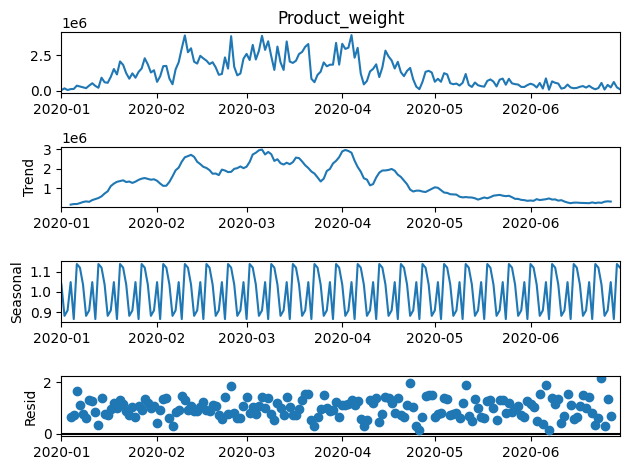

In [ ]:

from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
#series = read_csv('airline-passengers.csv', header=0, index_col=0)
df2 = df1.copy()
df2['Month'] = df2['Date'].dt.month
df2['Year'] = df2['Date'].dt.year

s = df2[(df2.Year==2020)&(df2.Month.isin([1,2,3,4,5,6]))].set_index('Date')["Product_weight"]
result = seasonal_decompose(s, model='multiplicative')
result.plot()
pyplot.show()

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df1,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 14
horizon = 14
train,val,test = split_train_val_test(df1, train_size = 0.7, val_size = 0.1, test_size = 0.2)
X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)

In [ ]:
df1

,Date,Product_weight
0,2000-01-01,1.094000e+03
1,2000-01-02,1.293180e+05
2,2000-01-03,2.575420e+05
3,2000-01-04,3.749000e+04
4,2000-01-05,7.420800e+04
...,...,...
8507,2023-04-17,1.327499e+06
8508,2023-04-18,2.241853e+06
8509,2023-04-19,8.557609e+05
8510,2023-04-20,7.548127e+05


In [ ]:
X_train.shape
y_train.shape

(5931, 14)

# Time series models

In [ ]:
from sklearn.metrics import *
def get_metrics(g,p):
  print('Kết quả đánh giá:')
  print('MSE:',mean_squared_error(g,p))
  print('RMSE:',np.sqrt(mean_squared_error(g,p)))
  print('MAE:',mean_absolute_error(g,p))
  print('MAPE:',mean_absolute_percentage_error(g,p))
  print('R2:',r2_score(g,p))

### 1. Linear Regresion

Validation set
Kết quả đánh giá:
MSE: 43168648488.86696
RMSE: 207770.66320553285
MAE: 167279.94636486867
MAPE: 3.662201761204905
R2: -0.225326530927493

Test set
Kết quả đánh giá:
MSE: 59518605035.51506
RMSE: 243964.35197691293
MAE: 208950.69794857042
MAPE: 21.11931029986895
R2: -0.5922389963489416


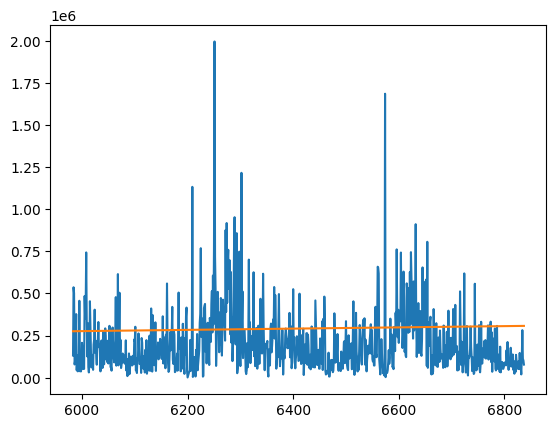

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

model_LR = LinearRegression()
model_LR.fit(np.array(train.index).reshape(-1,1),
             train['Product_weight'].values.reshape(-1,1))

pred_val = model_LR.predict(np.array(val.index).reshape(-1,1))


pred_test = model_LR.predict(np.array(test.index).reshape(-1,1))

print('Validation set')
get_metrics(val['Product_weight'],pred_val)

print('\nTest set')
get_metrics(test['Product_weight'],pred_test)

plt.plot(val['Product_weight'])
plt.plot(np.array(val.index).reshape(-1,1),pred_val)

In [ ]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train,y_train)

pred_val = model_LR.predict(X_val)
pred_test = model_LR.predict(X_test)

print('Validation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

Validation set
Kết quả đánh giá:
MSE: 31555936700.92991
RMSE: 177639.90739957592
MAE: 118715.55876977081
MAPE: 0.6166207677672617
R2: -3.910868053009166

Test set
Kết quả đánh giá:
MSE: 31415435525.121346
RMSE: 177243.99996931164
MAE: 111086.37756392857
MAPE: 0.6023956388445221
R2: -2.653627843503798


In [ ]:
# i=5
# plt.figure(figsize=(12,5))
# plt.plot(range(i,i+lookback+horizon),X_val[i].tolist()+y_val[i].tolist())
# plt.plot(range(i+lookback,i+lookback+horizon),y_val[i])

# plt.plot(range(i,i+lookback+horizon),X_val[i].tolist()+pred_val[i].tolist())
# plt.plot(range(i+lookback,i+lookback+horizon),pred_val[i])
# plt.grid()
# plt.show()

### 2. Simple RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import math

model_RNN = Sequential()
model_RNN.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (14,) ve (14,1)
model_RNN.add(SimpleRNN(32, activation='relu', return_sequences=True))
model_RNN.add(SimpleRNN(64, activation='relu', return_sequences=False))
model_RNN.add(Dense(horizon))

loss = MeanSquaredError()
optimizer = Adam(learning_rate=0.01)


model_RNN.compile(optimizer=optimizer, loss=loss)
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 14, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 14, 32)            1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 14)                910       
                                                                 
Total params: 8,206
Trainable params: 8,206
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = MeanSquaredError()
optimizer = Adam(learning_rate=0.01)

learning_rate=0.01
batch_size=32
epochs=10

In [ ]:
from keras.callbacks import ModelCheckpoint

save_best = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_RNN.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32,epochs=10, callbacks=[save_best])

Epoch 1/10
186/186 [==============================] - 9s 26ms/step - loss: 281500909568.0000 - val_loss: 438664986624.0000
Epoch 2/10
186/186 [==============================] - 5s 28ms/step - loss: 255414812672.0000 - val_loss: 434557583360.0000
Epoch 3/10
186/186 [==============================] - 5s 27ms/step - loss: 270118141952.0000 - val_loss: 460290686976.0000
Epoch 4/10
186/186 [==============================] - 4s 24ms/step - loss: 259767058432.0000 - val_loss: 424065236992.0000
Epoch 5/10
186/186 [==============================] - 5s 28ms/step - loss: 253802774528.0000 - val_loss: 486187827200.0000
Epoch 6/10
186/186 [==============================] - 4s 23ms/step - loss: 254976098304.0000 - val_loss: 407411261440.0000
Epoch 7/10
186/186 [==============================] - 5s 27ms/step - loss: 240859103232.0000 - val_loss: 417827454976.0000
Epoch 8/10
186/186 [==============================] - 5s 24ms/step - loss: 244111458304.0000 - val_loss: 416799227904.0000
Epoch 9/10
186/1

In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_RNN.load_weights('best.hdf5')
pred_val = model_RNN.predict(X_val)
pred_test = model_RNN.predict(X_test)

print('\nValidation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

53/53 [==============================] - 0s 4ms/step

Validation set
Kết quả đánh giá:
MSE: 402482258964.2562
RMSE: 634414.8949735151
MAE: 435918.91284046165
MAPE: 0.6212301254518847
R2: 0.33151986597589556

Test set
Kết quả đánh giá:
MSE: 412362750264.7233
RMSE: 642154.77126992
MAE: 418261.688294927
MAPE: 0.6488219541088088
R2: 0.26874309610047253


### 3. LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import math

model_LSTM = Sequential()
model_LSTM.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (14,) ve (14,1)
model_LSTM.add(LSTM(32, activation='relu', return_sequences=True))
model_LSTM.add(LSTM(64, activation='relu', return_sequences=False))
model_LSTM.add(Dense(horizon))

optimizer = Adam(learning_rate=0.01)
loss = MeanSquaredError()

model_LSTM.compile(optimizer=optimizer, loss=loss)
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 14, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 14, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 14)                910       
                                                                 
Total params: 30,094
Trainable params: 30,094
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

save_best = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_LSTM.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32,epochs=10, callbacks=[save_best])

Epoch 1/10
186/186 [==============================] - 12s 54ms/step - loss: 405960720384.0000 - val_loss: 463305179136.0000
Epoch 2/10
186/186 [==============================] - 10s 53ms/step - loss: 283792637952.0000 - val_loss: 547568943104.0000
Epoch 3/10
186/186 [==============================] - 9s 51ms/step - loss: 377126748160.0000 - val_loss: 514502164480.0000
Epoch 4/10
186/186 [==============================] - 9s 50ms/step - loss: 303019261952.0000 - val_loss: 489500999680.0000
Epoch 5/10
186/186 [==============================] - 9s 49ms/step - loss: 281611796480.0000 - val_loss: 476092760064.0000
Epoch 6/10
186/186 [==============================] - 9s 51ms/step - loss: 275556237312.0000 - val_loss: 465272766464.0000
Epoch 7/10
186/186 [==============================] - 10s 52ms/step - loss: 266534551552.0000 - val_loss: 449484947456.0000
Epoch 8/10
186/186 [==============================] - 9s 50ms/step - loss: 262801522688.0000 - val_loss: 436123926528.0000
Epoch 9/10
18

In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_LSTM.load_weights('best.hdf5')
pred_val = model_LSTM.predict(X_val)
pred_test = model_LSTM.predict(X_test)

print('\nValidation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

53/53 [==============================] - 0s 5ms/step

Validation set
Kết quả đánh giá:
MSE: 436123928331.96454
RMSE: 660396.7961248484
MAE: 441995.5270714907
MAPE: 0.6742033278550806
R2: 0.20693447011761418

Test set
Kết quả đánh giá:
MSE: 452171629218.903
RMSE: 672437.0819778629
MAE: 433213.84964963136
MAPE: 0.7261795828479717
R2: 0.031258267164030275


### 4. GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Reshape,Dense, SimpleRNN,LSTM,GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import math

model_GRU = Sequential()
model_GRU.add(Reshape((lookback, 1), input_shape=(lookback,))) # chuyen shape (14,) ve (14,1)
model_GRU.add(GRU(32, activation='relu', return_sequences=True))
model_GRU.add(GRU(64, activation='relu', return_sequences=True))
model_GRU.add(GRU(32, activation='relu', return_sequences=False))
model_GRU.add(Dense(horizon))

optimizer = Adam(learning_rate=0.01)
loss = MeanSquaredError()

model_GRU.compile(optimizer=optimizer, loss=loss)
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 14, 1)             0         
                                                                 
 gru (GRU)                   (None, 14, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 14, 64)            18816     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 32,046
Trainable params: 32,046
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

save_best = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_GRU.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32,epochs=10, callbacks=[save_best])

Epoch 1/10
186/186 [==============================] - 21s 93ms/step - loss: 309160214528.0000 - val_loss: 427291738112.0000
Epoch 2/10
186/186 [==============================] - 18s 94ms/step - loss: 259151888384.0000 - val_loss: 431431942144.0000
Epoch 3/10
186/186 [==============================] - 17s 91ms/step - loss: 278794960896.0000 - val_loss: 592318889984.0000
Epoch 4/10
186/186 [==============================] - 18s 96ms/step - loss: 261765939200.0000 - val_loss: 464138600448.0000
Epoch 5/10
186/186 [==============================] - 17s 89ms/step - loss: 263945535488.0000 - val_loss: 444607922176.0000
Epoch 6/10
186/186 [==============================] - 18s 95ms/step - loss: 255427100672.0000 - val_loss: 449171914752.0000
Epoch 7/10
186/186 [==============================] - 17s 89ms/step - loss: 253646471168.0000 - val_loss: 410573504512.0000
Epoch 8/10
186/186 [==============================] - 18s 98ms/step - loss: 271026733056.0000 - val_loss: 424802353152.0000
Epoch 9/

In [ ]:
# load trang thai mo hinh tot nhat (val loss nho nhat)
model_GRU.load_weights('best.hdf5')
pred_val = model_GRU.predict(X_val)
pred_test = model_GRU.predict(X_test)

print('\nValidation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

53/53 [==============================] - 1s 10ms/step

Validation set
Kết quả đánh giá:
MSE: 410573496381.70013
RMSE: 640760.0926881294
MAE: 438945.91018119024
MAPE: 0.6490313578063914
R2: 0.4067466948653057

Test set
Kết quả đánh giá:
MSE: 423455345402.71484
RMSE: 650734.4661247896
MAE: 423623.08346129773
MAPE: 0.6696439487468895
R2: 0.29203645040658094


In [ ]:
Validation set
Kết quả đánh giá:
MSE: 411263726762.56
RMSE: 641298.4693280968
MAE: 443903.58958047855
MAPE: 0.6301624661468637
R2: 0.34866759519496754

Test set
Kết quả đánh giá:
MSE: 434171094594.42316
RMSE: 658916.6067071182
MAE: 435086.27767173946
MAPE: 0.6564203565589415
R2: 0.21487095588722574

SyntaxError: ignored

### 5. Seq2Seq

In [ ]:
%%capture
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
!pip install ipython-autotime

%load_ext autotime
exit() # restart the runtime to refresh installed pkg

In [ ]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster
#from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
#from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster
#from bigdl.orca.automl.metrics import Evaluator
import json 
from json import loads
import time
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time

In [ ]:
df = pd.read_csv('/content/species1.csv',parse_dates=['Last_catch_date'])
df1 = pd.DataFrame()
df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-04-21' )
df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                          if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
# xử lý missing
df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear')
df1.info()

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 14
horizon = 14
train,val,test = split_train_val_test(df1, train_size = 0.7, val_size = 0.1, test_size = 0.2)
X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)

In [ ]:
X_train = np.expand_dims(X_train,axis=-1)
X_val = np.expand_dims(X_val,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

y_train = np.expand_dims(y_train,axis=-1)
y_val = np.expand_dims(y_val,axis=-1)
y_test = np.expand_dims(y_test,axis=-1)

In [ ]:
import random
import torch
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
set_seed()
feature_dim = X_train.shape[-1] # 1, số feature đầu vào (chỉ product weight của 14 ngày trước)
target_dim = 1 # số feature đầu ra, (chỉ product weight 14 ngày tiếp theo)
learning_rate = 0.01
drop = 0.1

seq2seqforecaster = Seq2SeqForecaster(past_seq_len=lookback,
                              future_seq_len = horizon,
                              input_feature_num=feature_dim,
                              output_feature_num=target_dim,
                              lstm_hidden_dim=64,
                              lstm_layer_num=2,
                              lr=learning_rate,
                              loss='mse',
                              seed=42,
                              metrics = 'rmse',
                              dropout=drop,
                              optimizer='Adam',
                              )

In [ ]:
set_seed()
batch_size = 32
epochs = 10
seq2seqforecaster.fit(data=(X_train.astype('float32'), y_train.astype('float32')), 
                  validation_data =(X_val.astype('float32'),y_val.astype('float32')),
                  batch_size = batch_size, 
                  epochs = epochs)

In [ ]:
pred_val = seq2seqforecaster.predict(X_val.astype('float32'))
pred_test = seq2seqforecaster.predict(X_test.astype('float32'))

print('\nValidation set')
get_metrics(pred_val[:,:,0],y_val[:,:,0])

print('\nTest set')
get_metrics(pred_test[:,:,0],y_test[:,:,0])

In [ ]:
for i in range(1):
  plt.figure(figsize=(16,5))
  plt.plot(y_val[-90:,i])
  plt.plot(pred_val[-90:,i])
  plt.grid()
  plt.legend(['ground truth','predicted'])
  plt.show()

### 6. KNN

<Axes: xlabel='Date'>

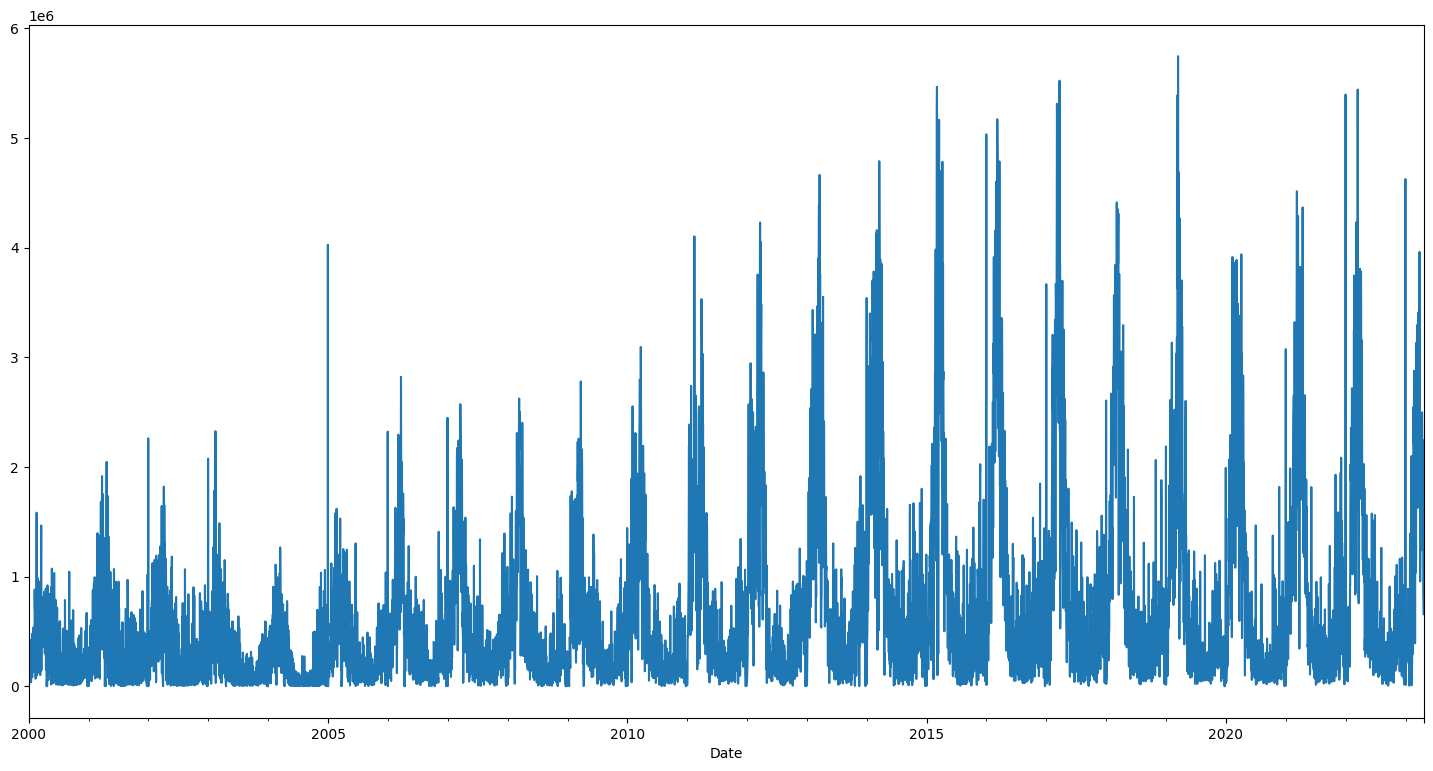

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,9))
df1.set_index('Date')['Product_weight'].plot()

### 7. TCN

In [ ]:
%%capture
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
!pip install ipython-autotime

%load_ext autotime
exit() # restart the runtime to refresh installed pkg

In [ ]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster
#from bigdl.orca.automl.metrics import Evaluator
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import json 
from json import loads
import time
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [ ]:
df = pd.read_csv('/content/species1.csv',parse_dates=['Last_catch_date'])
df1 = pd.DataFrame()
df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-04-21' )
df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                          if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
# xử lý missing
df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear')
df1.info()

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 14
horizon = 14
train,val,test = split_train_val_test(df1, train_size = 0.7, val_size = 0.1, test_size = 0.2)
X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)

X_train = np.expand_dims(X_train,axis=-1)
X_val = np.expand_dims(X_val,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

y_train = np.expand_dims(y_train,axis=-1)
y_val = np.expand_dims(y_val,axis=-1)
y_test = np.expand_dims(y_test,axis=-1)

In [ ]:
import random
import torch
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
set_seed()


feature_dim = X_train.shape[-1] # 1, số feature đầu vào (chỉ product weight của 14 ngày trước)
target_dim =  y_train.shape[-1] # số feature đầu ra, (chỉ product weight 7 ngày tiếp theo)
learning_rate = 0.001
drop = 0.1

tcnforecaster = TCNForecaster(past_seq_len=lookback,
                              future_seq_len = horizon,
                              input_feature_num=feature_dim,
                              output_feature_num=target_dim,
                              lr=learning_rate,
                              loss='mse',
                              seed=42,
                              metrics = 'rmse',
                              kernel_size=3,
                              dropout=drop,
                              num_channels = [64]*3,
                              optimizer='Adam',
                              )

In [ ]:
set_seed()
batch_size = 32
epochs = 10
tcnforecaster.fit(data=(X_train.astype('float32'),y_train.astype('float32')), 
                  validation_data = (X_val.astype('float32'),y_val.astype('float32')),
                  batch_size = batch_size, 
                  epochs = epochs)


In [ ]:
pred_val = tcnforecaster.predict(X_val.astype('float32'))
pred_test = tcnforecaster.predict(X_test.astype('float32'))

print('\nValidation set')
get_metrics(pred_val[:,:,0],y_val[:,:,0])

print('\nTest set')
get_metrics(pred_test[:,:,0],y_test[:,:,0])

In [ ]:
plt.figure(figsize=(16,9))
test.set_index('Date').Product_weight.plot()
test

### 8. ARIMA

### 9. ETS

### 10. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_RF = RandomForestRegressor(n_estimators = 100, random_state=42)
model_RF.fit(X_train,y_train)

In [ ]:
pred_val = model_RF.predict(X_val)
pred_test = model_RF.predict(X_test)

print('Validation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)